# Visualize Top-K Nearest Lighting image

In [1]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import copy
import pytorch_lightning as pl
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
sys.path.insert(0, '../')
from sample_utils import ckpt_utils, params_utils, vis_utils, file_utils, img_utils, inference_utils, mani_utils

In [2]:
# Define loading settings 
set_ = "valid"
batch_size = 20
seed = 47
seed_all(seed)
if set_ == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
elif set_ == 'train' or set_ == 'valid':
    img_dataset_path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/"
else: raise NotImplementedError


[#] Model Path :  ['/data/mint/model_logs_mount/v9/cond_img64_by_deca_arcface/']
['/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml')

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


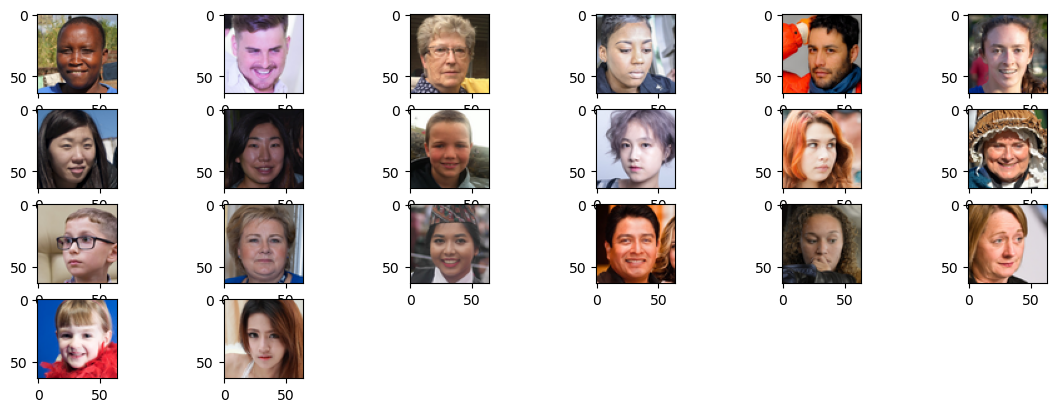

In [3]:
# Load params
cfg_name = "cond_img64_by_deca_arcface.yaml"
log_dir = "cond_img64_by_deca_arcface"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg

params_set = params_utils.get_params_set(set=set_, cfg=cfg)

rand_idx = np.random.choice(a=range(len(list(params_set.keys()))), replace=False, size=batch_size)
img_path = file_utils._list_image_files_recursively(img_dataset_path)
img_path = [img_path[r] for r in rand_idx]
img_name = [path.split('/')[-1] for path in img_path]

# Load condition & Images into model_kwargs
model_kwargs = mani_utils.load_condition(params_set, img_name)
images = mani_utils.load_image(all_path=img_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})

In [4]:
def distance(a, b, dist_type='l2'):
    if dist_type == 'l1':
        return np.sum(np.abs(a-b))
    elif dist_type == 'l2':
        return np.sum((a-b)**2)

def retrieve_topk_params(params_set, ref_params, cfg, img_dataset_path, dist_type, k=30):

    light_dist = []
    img_name_list = []
    for img_name in params_set.keys():
        light_dist.append(distance(params_set[img_name]['light'], ref_params, dist_type=dist_type))
        img_name_list.append(img_name)

    min_idx = np.argsort(light_dist)[:k]

    img_path = file_utils._list_image_files_recursively(img_dataset_path)
    img_path = [img_path[i] for i in min_idx]
    img_name = [path.split('/')[-1] for path in img_path]

    images = mani_utils.load_image(all_path=img_path, cfg=cfg, vis=True)['image']
    params_filtered = {k:params_set[k] for k in img_name}
    return images, params_filtered


[#] Dist-type = L1


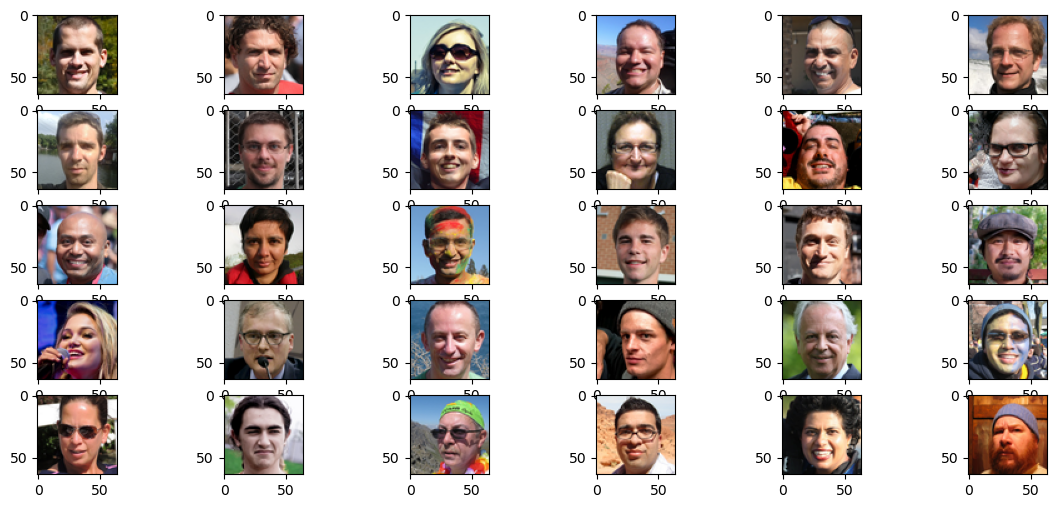

[#] Dist-type = L2


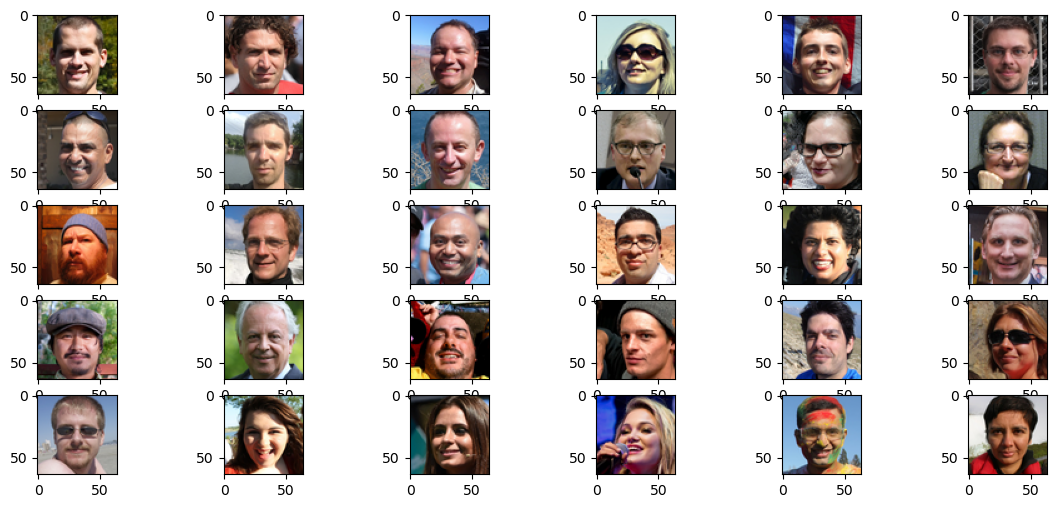

In [5]:
ref = '61231.jpg'
ref_params = params_set[ref]['light']
print("[#] Dist-type = L1")
images, params_filtered = retrieve_topk_params(params_set=params_set, ref_params=ref_params, cfg=cfg, img_dataset_path=img_dataset_path, k=30, dist_type='l1')
print("[#] Dist-type = L2")
images, params_filtered = retrieve_topk_params(params_set=params_set, ref_params=ref_params, cfg=cfg, img_dataset_path=img_dataset_path, k=30, dist_type='l2')

# Linear Classifier

In [6]:
import torch as th
class LinearClassifier(th.nn.Module):
    def __init__(self, cfg):
        super(LinearClassifier, self).__init__()
        self.cls = th.nn.Linear(cfg.param_model.light, 1)
        self.opt = th.optim.Adam(self.parameters())

    def forward(self, x):
        output = self.cls(x)
        return output
    
    def cal_loss(self, gt, pred):
        loss_fn = th.nn.BCEWithLogitsLoss()
        loss = loss_fn(pred, gt)
        return loss

    def train(self, gt, input, n_iters, progress=True):
        print(f"[#] Training Linear Classifier with iterations={n_iters}, samples_size={gt.shape[0]}")
        if progress:
            import tqdm
            t = tqdm.trange(n_iters, desc="")
        else:
            t = range(n_iters)
        for i in t:
            self.opt.zero_grad()
            pred = self.forward(input)
            loss = self.cal_loss(gt=gt, pred=pred)
            loss.backward()
            self.opt.step()
            if i % 500 == 0 and progress:
                t.set_description(f"[#] Loss = {loss}")
                t.refresh() # to show immediately the update

    def evaluate(self, gt, input):
        sigmoid = th.nn.Sigmoid()
        pred = self.forward(input.cuda().float())
        pred = sigmoid(pred) > 0.5
        accuracy = (th.sum(pred == gt.cuda()) / pred.shape[0]) * 100
        print(f"[#] Accuracy = {accuracy}")


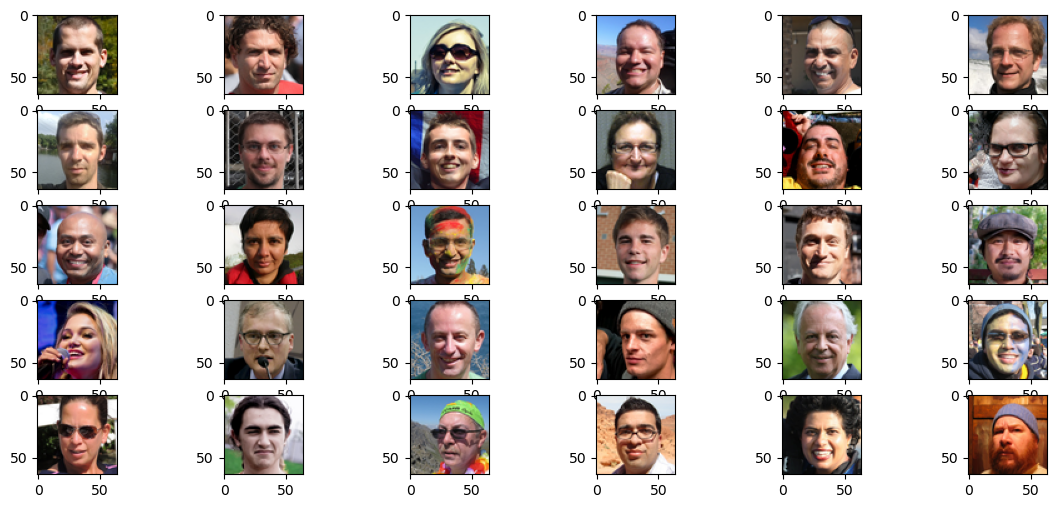

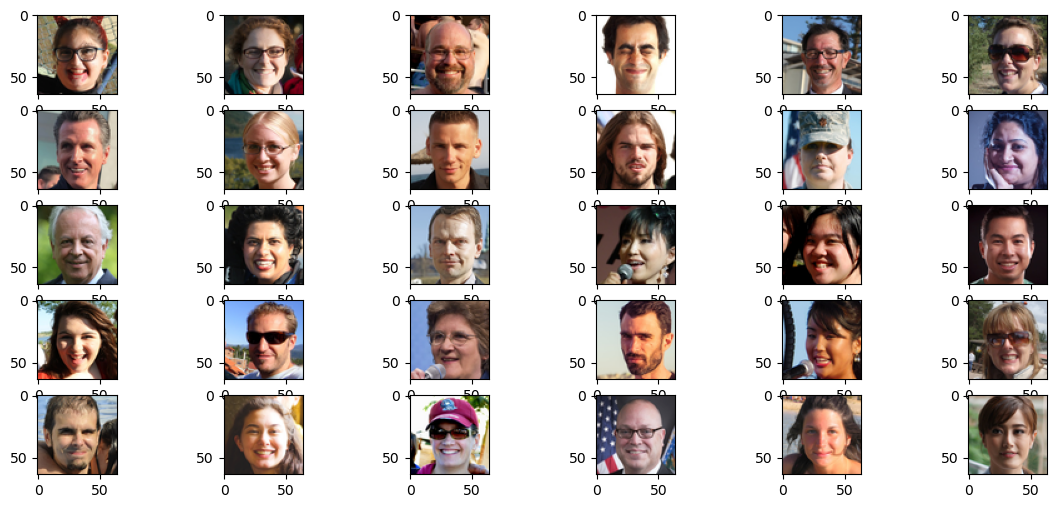

In [7]:
'''
Prepare data
 - Positive class = destination = 1
 - Negative class = source = 0
'''
k = 30
# Source = label as 0
src_ref = '61231.jpg'
ref_params = params_set[src_ref]['light']
src_images, src_params_dict = retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l1')
src_label = th.zeros(k)
# Destination = label as 1
dst_ref = '63316.jpg'
ref_params = params_set[dst_ref]['light']
dst_images, dst_params_dict = retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l1')
dst_label = th.ones(k)

src_params = [v['light'] for k, v in src_params_dict.items()]
dst_params = [v['light'] for k, v in dst_params_dict.items()]
src_params = np.stack(src_params, axis=0)
dst_params = np.stack(dst_params, axis=0)

input = np.concatenate((src_params, dst_params), axis=0)
input = th.tensor(input)
gt = th.cat((src_label, dst_label))[..., None]


In [8]:
seed_all(47)
cls_model = LinearClassifier(cfg).cuda()
cls_model.train(gt=gt.cuda(), input=input.float().cuda(), n_iters=50000, progress=True)

for k, v in cls_model.named_parameters():
    print(k, v, v.shape)

[#] Training Linear Classifier with iterations=50000, samples_size=60


[#] Loss = 0.04638947173953056: 100%|██████████| 50000/50000 [00:22<00:00, 2254.28it/s] 

cls.weight Parameter containing:
tensor([[  1.78093, -11.29225,  -0.15443,  27.57932,   8.21621, -20.60332,
         -40.01404, -40.25002, -40.43970, -12.31954, -35.57353, -11.42475,
           8.20884,  17.37334, -17.81985,  12.57577,  30.03300, -25.68348,
          -9.59407,  12.27968, -22.92813,  15.13653,   8.98234,  15.90624,
           8.19914, -23.12339,  -6.91728]], device='cuda:0',
       requires_grad=True) torch.Size([1, 27])
cls.bias Parameter containing:
tensor([2.18029], device='cuda:0', requires_grad=True) torch.Size([1])


In [9]:
cls_model.evaluate(gt=gt.cuda(), input=input.float().cuda())
print(th.nn.functional.normalize(cls_model.cls.weight, dim=1))

[#] Accuracy = 96.66667175292969
tensor([[ 0.01614, -0.10234, -0.00140,  0.24994,  0.07446, -0.18672, -0.36264,
         -0.36478, -0.36649, -0.11165, -0.32239, -0.10354,  0.07439,  0.15745,
         -0.16150,  0.11397,  0.27218, -0.23276, -0.08695,  0.11129, -0.20779,
          0.13718,  0.08140,  0.14415,  0.07431, -0.20956, -0.06269]],
       device='cuda:0', grad_fn=<DivBackward0>)
